In [1]:
!pip install -qq arff2pandas

!pip install -q -U watermark
!pip install -qq -U pandas

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Joyce\\anaconda3\\Lib\\site-packages\\~andas\\_libs\\algos.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,arff2pandas

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

numpy      : 1.20.1
pandas     : 1.3.4
torch      : 1.8.1
arff2pandas: 1.0.1



In [ ]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
    time_series_df = pd.DataFrame(data)

    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()

    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]

    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(
        path_deviation.index,
        under_line,
        over_line,
        alpha=.125
      )
    ax.set_title(class_name)
    
def create_dataset(df):

    sequences = df.astype(np.float32).to_numpy().tolist()

    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

    n_seq, seq_len, n_features = torch.stack(dataset).shape

    return dataset, seq_len, n_features

"""## Training

Let's write a helper function for our training process:
"""

def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
  
    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:

                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    return model.eval(), history


def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])

    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()


In [ ]:
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        #self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        self.embedding_dim, self.hidden_dim = embedding_dim, embedding_dim

        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
    
    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))

        #x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn1(x)
        #x, (hidden_n, _) = self.rnn2(x)

        return hidden_n.reshape((self.n_features, self.embedding_dim))

"""The *Encoder* uses LSTM layers to compress the Time Series data input.
Next, we'll decode the compressed representation using a *Decoder*:
"""

class Decoder(nn.Module):

    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        # self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.hidden_dim, self.n_features = input_dim, n_features

        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim, 
          num_layers=1, 
          batch_first=True
        )

        # self.rnn2 = nn.LSTM(
        #   input_size=input_dim,
        #   hidden_size=self.hidden_dim,
        #   num_layers=1,
        #   batch_first=True
        # )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))

        x, (hidden_n, cell_n) = self.rnn1(x)
        #x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.output_layer(x)

#Our Decoder contains LSTM layer and an output layer that gives the final reconstruction.

#Time to wrap everything into an easy to use module:


class RecurrentAutoencoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x


In [ ]:
"""
# Time Series Anomaly Detection using LSTM Autoencoders with PyTorch in Python

# Uncomment the "pip" commands as necessary to install the packages

# Needed to access the data files
# !pip install -qq arff2pandas

# 
# !pip install -q -U watermark

# !pip install -qq -U pandas

# Commented out IPython magic to ensure Python compatibility.
# %reload_ext watermark
# %watermark -v -p numpy,pandas,torch,arff2pandas

# Commented out IPython magic to ensure Python compatibility.
"""
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
from arff2pandas import a2p


# %matplotlib inline
# %config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

"""
In this tutorial, you'll learn how to detect anomalies in Time Series data using an LSTM Autoencoder. 
You're going to use real-world ECG data from a single patient with heart disease to detect abnormal hearbeats.

# Data
The [dataset](http://timeseriesclassification.com/description.php?Dataset=ECG5000) contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

> An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart. [Source](https://www.heartandstroke.ca/heart/tests/electrocardiogram)

We have 5 types of hearbeats (classes):

- Normal (N) 
- R-on-T Premature Ventricular Contraction (R-on-T PVC)
- Premature Ventricular Contraction (PVC)
- Supra-ventricular Premature or Ectopic Beat (SP or EB) 
- Unclassified Beat (UB).

> Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle.
Frequency: 60–100 per minute (Humans)
Duration: 0.6–1 second (Humans) [Source](https://en.wikipedia.org/wiki/Cardiac_cycle)
"""

#Load the arff files into Pandas data frames / Change Path as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with open('ECG5000_TRAIN.arff') as f:
      train = a2p.load(f)

with open('ECG5000_TEST.arff') as f:
      test = a2p.load(f)

#We'll combine the training and test data into a single data frame. This will give us more data to train our Autoencoder. We'll also shuffle it:"""

df = train.append(test)
df = df.sample(frac=1.0)
df.shape

df.head()

"""We have 5,000 examples. Each row represents a single heartbeat record. Let's name the possible classes:"""

CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']

"""Next, we'll rename the last column to `target`, so its easier to reference it:"""

new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

"""## Exploratory Data Analysis

Let's check how many examples for each heartbeat class do we have:
"""

df.target.value_counts()

"""Let's plot the results:"""

ax = sns.countplot(df.target)
ax.set_xticklabels(class_names);

"""The normal class, has by far, the most examples. 

Let's have a look at an averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class:
"""



classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.target == cls] \
        .drop(labels='target', axis=1) \
        .mean(axis=0) \
        .to_numpy()
    plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();
plt.show()

## LSTM Autoencoder

### Data Preprocessing

#Let's get all normal heartbeats and drop the target (class) column:

normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

#Merge all other classes and mark them as anomalies:"""

anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

#Split the normal examples into train, validation and test sets:"""

train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

#Convert our examples into tensors, so we can use them to train our Autoencoder. 



#Each Time Series will be converted to a 2D Tensor in the shape *sequence length* x *number of features* (140x1 in our case).

#Create Train, Val and Test datasets:

train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)



In [18]:
def function275(threshold):
    # LSTM Autoencoder
    #The general Autoencoder architecture consists of two components. An *Encoder* that compresses the input and a *Decoder* that tries to reconstruct it.


    """Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:"""

    #model = RecurrentAutoencoder(seq_len, n_features, 128)
    #model = RecurrentAutoencoder(seq_len, n_features, 8)
    model = RecurrentAutoencoder(seq_len, n_features, 8)
    model = model.to(device)


    """At each epoch, the training process feeds our model with all training examples and evaluates the performance on the validation set. Note that we're using a batch size of 1 (our model sees only 1 sequence at a time). We also record the training and validation set losses during the process.

    Note that we're minimizing the [L1Loss](https://pytorch.org/docs/stable/nn.html#l1loss), which measures the MAE (mean absolute error). Why? The reconstructions seem to be better than with MSE (mean squared error).

    We'll get the version of the model with the smallest validation error. Let's do some training:
    """

    model, history = train_model(
      model, 
      train_dataset, 
      val_dataset, 
      n_epochs=50
    #  n_epochs=25  
    )
    
    ax = plt.figure().gca()

    ax.plot(history['train'])
    ax.plot(history['val'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'])
    plt.title('Loss over training epochs')
    plt.show();

    ## Saving the model

    #Let's store the model for later use:


    MODEL_PATH = 'model.pth'

    torch.save(model, MODEL_PATH)

    """## Choosing a threshold
    """



    _, losses = predict(model, train_dataset)

    sns.distplot(losses, bins=50, kde=True);

    THRESHOLD = threshold

    """## Evaluation

    Using the threshold, we can turn the problem into a simple binary classification task:

    - If the reconstruction loss for an example is below the threshold, we'll classify it as a *normal* heartbeat
    - Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

    ### Normal hearbeats

    Let's check how well our model does on normal heartbeats. We'll use the normal heartbeats from the test set (our model haven't seen those):
    """

    predictions, pred_losses = predict(model, test_normal_dataset)
    sns.distplot(pred_losses, bins=50, kde=True);

    """We'll count the correct predictions:"""

    correct = sum(l <= THRESHOLD for l in pred_losses)
    print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

    """### Anomalies

    We'll do the same with the anomaly examples, but their number is much higher. We'll get a subset that has the same size as the normal heartbeats:
    """

    anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
    #anomaly_dataset = test_anomaly_dataset
    """Now we can take the predictions of our model for the subset of anomalies:"""

    predictions, pred_losses = predict(model, anomaly_dataset)
    sns.distplot(pred_losses, bins=50, kde=True);

    """Finally, we can count the number of examples above the threshold (considered as anomalies):"""

    correct = sum(l > THRESHOLD for l in pred_losses)
    print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

    #### Looking at Examples

    #We can overlay the real and reconstructed Time Series values to see how close they are. We'll do it for some normal and anomaly cases:


    fig, axs = plt.subplots(
      nrows=2,
      ncols=6,
      sharey=True,
      sharex=True,
      figsize=(22, 8)
    )

    for i, data in enumerate(test_normal_dataset[:6]):
        plot_prediction(data, model, title='Normal', ax=axs[0, i])

    for i, data in enumerate(test_anomaly_dataset[:6]):
        plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

    fig.tight_layout();

Epoch 1: train loss 73.4555969376662 val loss 68.22878688512809
Epoch 2: train loss 69.02803605528236 val loss 69.90973292275908
Epoch 3: train loss 66.43538326738535 val loss 60.644355135972994
Epoch 4: train loss 55.9991982708723 val loss 53.22083627485985
Epoch 5: train loss 52.68265341328594 val loss 51.0809890825187
Epoch 6: train loss 51.58788063313777 val loss 51.116544261320456
Epoch 7: train loss 50.95154445606679 val loss 49.82029981906096
Epoch 8: train loss 50.51156804178185 val loss 49.85034056002776
Epoch 9: train loss 49.99723267776262 val loss 49.25543057308262
Epoch 10: train loss 49.743148620740776 val loss 49.01389632371505
Epoch 11: train loss 49.51542868992822 val loss 48.73908524627165
Epoch 12: train loss 49.58665887831873 val loss 49.45116570378326
Epoch 13: train loss 49.16711982917709 val loss 48.50939992182084
Epoch 14: train loss 48.372969091154786 val loss 47.257102549686365
Epoch 15: train loss 47.467950101342716 val loss 46.810655157720674
Epoch 16: train

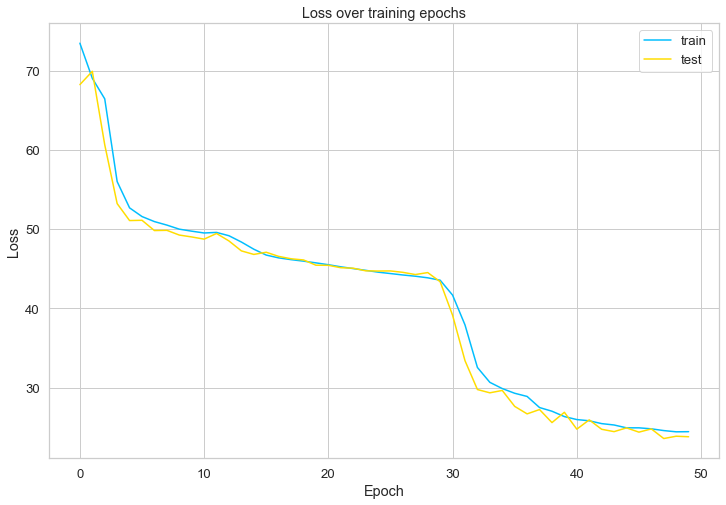

C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Correct normal predictions: 144/145


C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Correct anomaly predictions: 119/145


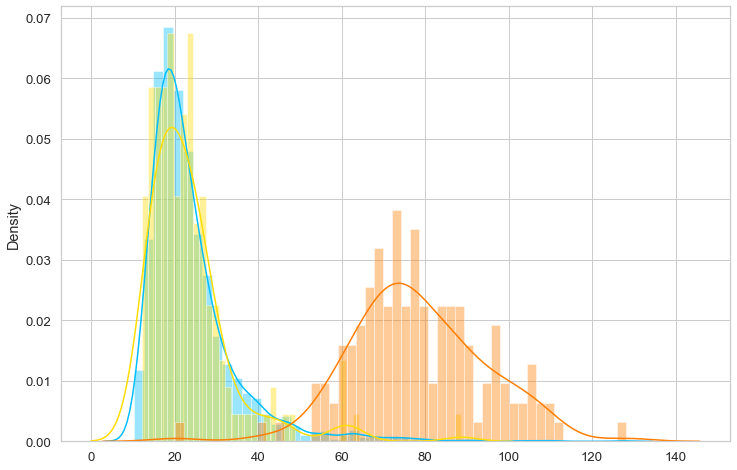

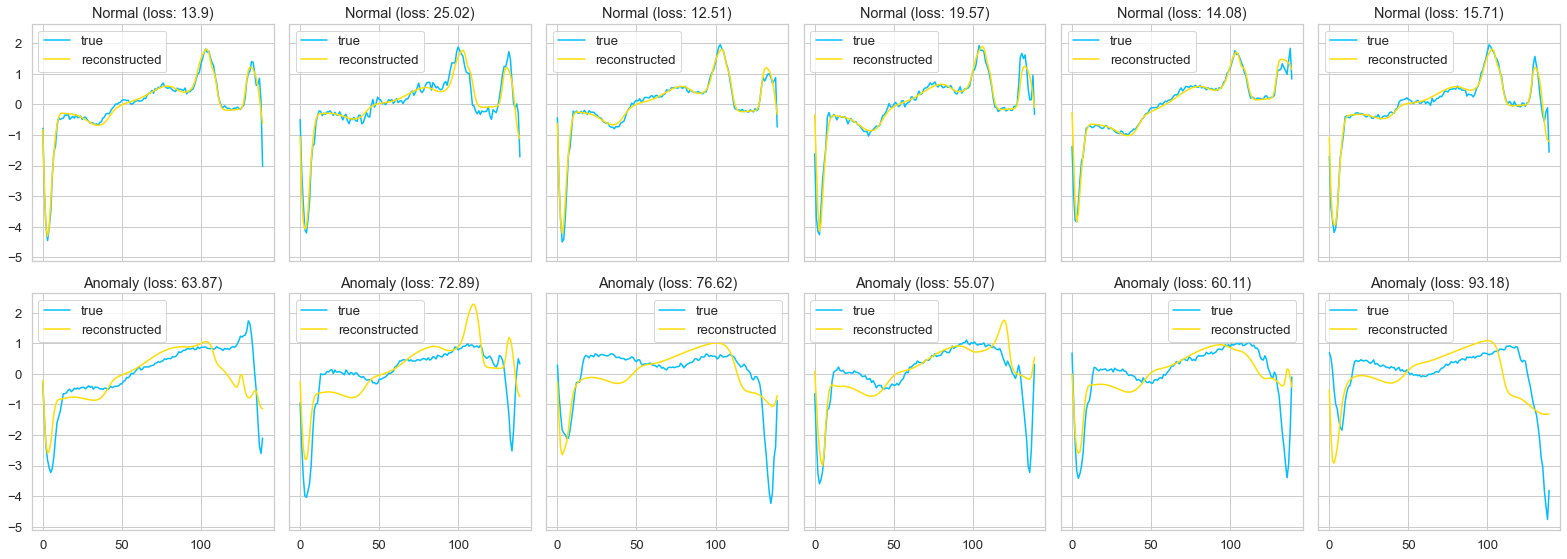

In [19]:
function275(65)

Epoch 1: train loss 78.1353083406423 val loss 68.68294875369544
Epoch 2: train loss 69.17404817660362 val loss 68.89127125919069
Epoch 3: train loss 64.15477392741722 val loss 59.12147497235711
Epoch 4: train loss 54.74118077663682 val loss 50.23585437345017
Epoch 5: train loss 51.05428555760351 val loss 48.71069559871947
Epoch 6: train loss 56.256265870124665 val loss 74.7976225765085
Epoch 7: train loss 59.14762418839971 val loss 51.394545896875165
Epoch 8: train loss 50.92057820896331 val loss 49.58652588775947
Epoch 9: train loss 49.513026633795015 val loss 48.9192491602979
Epoch 10: train loss 47.8044261155903 val loss 47.58164497609838
Epoch 11: train loss 45.838434868212524 val loss 52.552998988701624
Epoch 12: train loss 47.25095726145414 val loss 46.095426051689905
Epoch 13: train loss 43.92729899980329 val loss 41.46943158094387
Epoch 14: train loss 41.135016907611615 val loss 40.05997889521993
Epoch 15: train loss 39.339194794808215 val loss 38.887964391871115
Epoch 16: trai

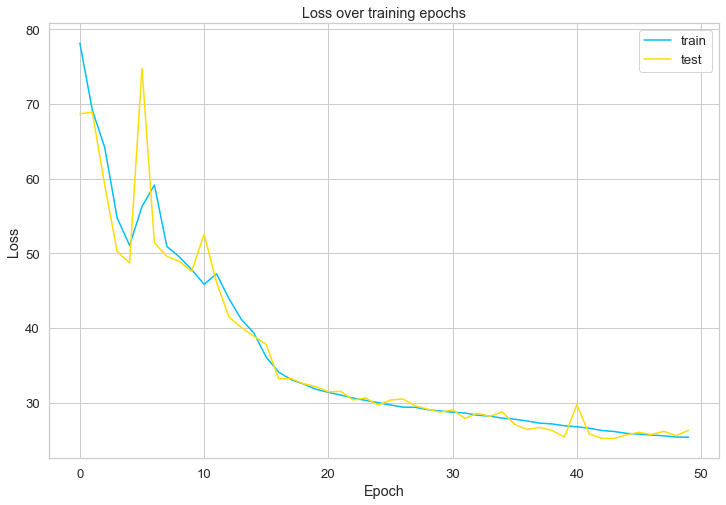

C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Correct normal predictions: 144/145


C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Correct anomaly predictions: 73/145


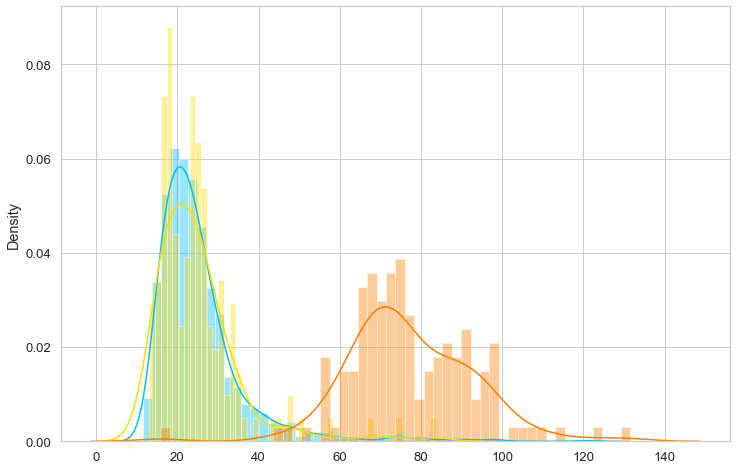

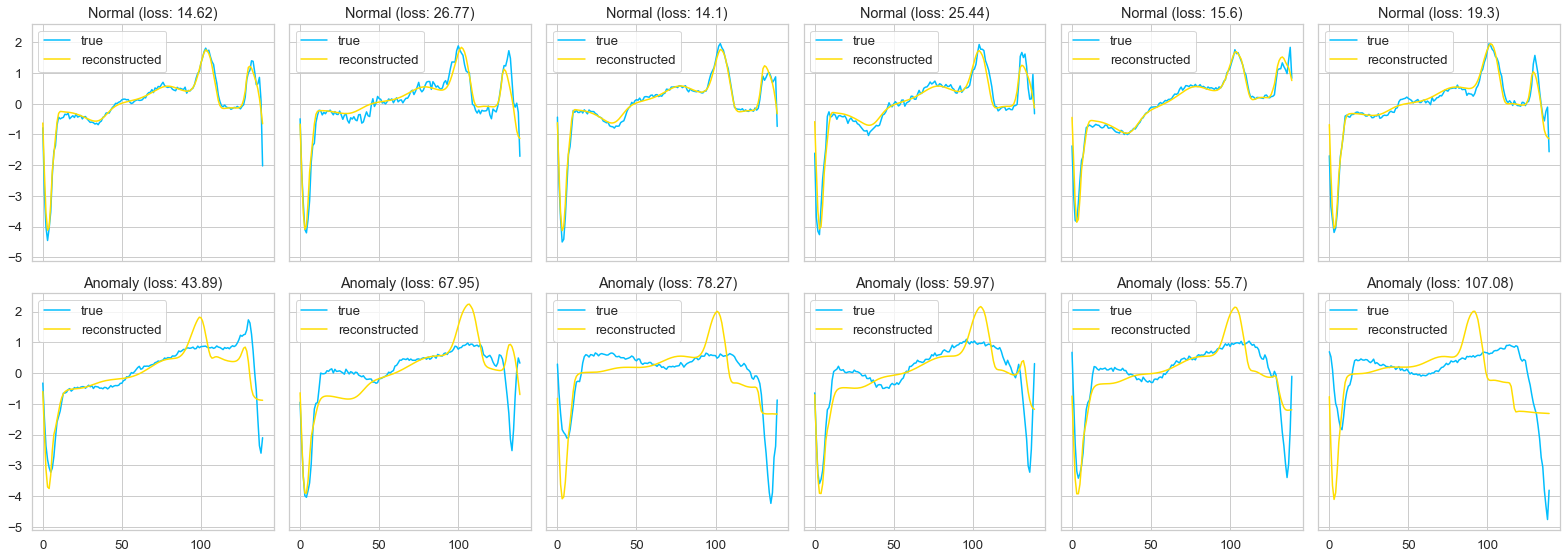

In [15]:
function275(75, 50)

Epoch 1: train loss 75.82964780377746 val loss 71.09266799301824
Epoch 2: train loss 68.44882481985158 val loss 68.96890726187124
Epoch 3: train loss 64.22726247619113 val loss 59.198448975338465
Epoch 4: train loss 55.70351962051484 val loss 53.90327557768838
Epoch 5: train loss 52.839792675185905 val loss 50.34308436787576
Epoch 6: train loss 49.33661330029735 val loss 48.49864716253183
Epoch 7: train loss 47.792637023556765 val loss 47.22108713351826
Epoch 8: train loss 46.34815630438058 val loss 39.962267013133186
Epoch 9: train loss 40.23970210633899 val loss 38.20228763489186
Epoch 10: train loss 38.9761311101702 val loss 37.43960404640172
Epoch 11: train loss 38.21182112211376 val loss 37.15383593458365
Epoch 12: train loss 37.7721321939317 val loss 37.71839831876267
Epoch 13: train loss 37.08090356106433 val loss 35.18868646849544
Epoch 14: train loss 36.62662921015268 val loss 37.023053803948414
Epoch 15: train loss 35.906273653890665 val loss 36.99956357519781
Epoch 16: train

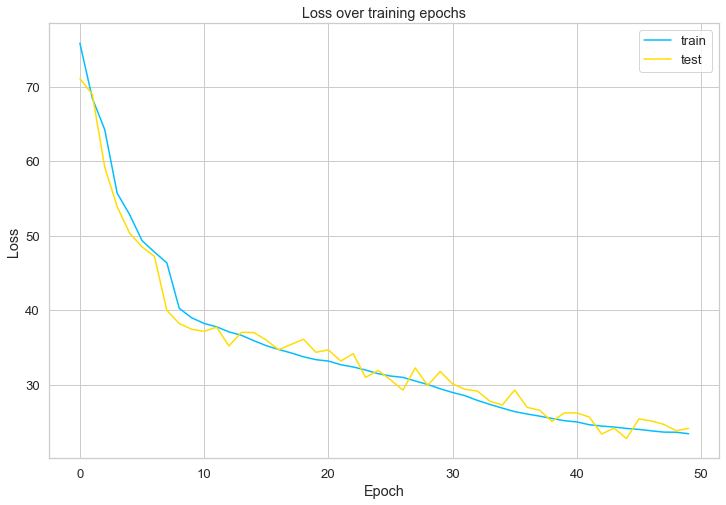

C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Correct normal predictions: 21/145


C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Correct anomaly predictions: 145/145


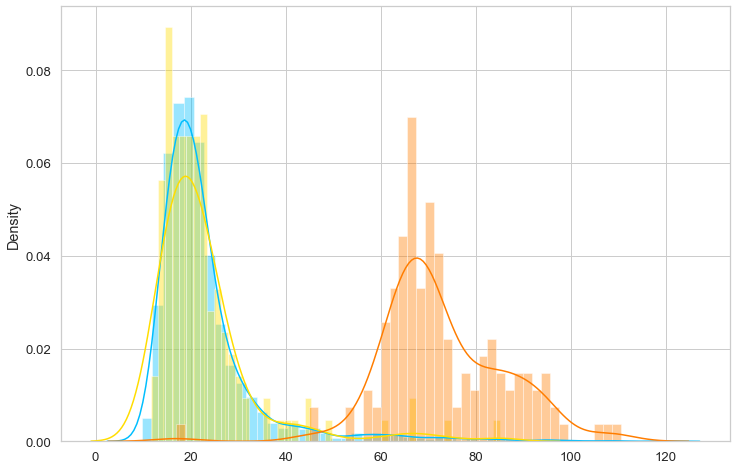

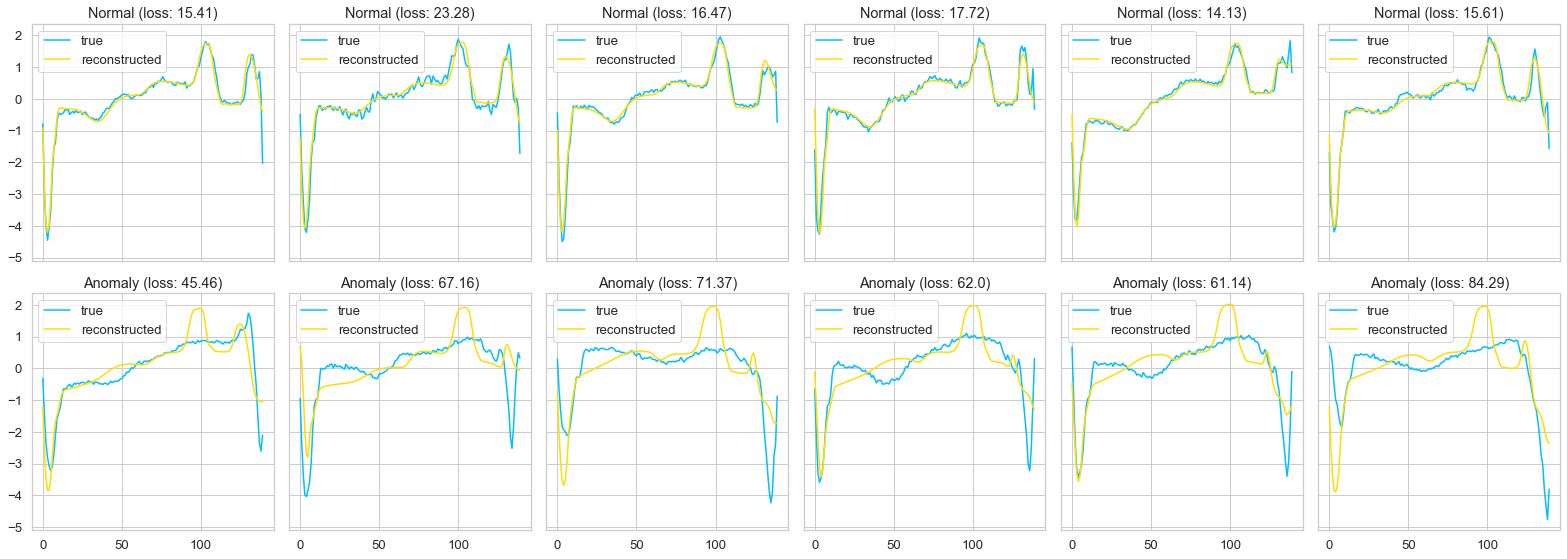

In [16]:
function275(15, 50)

Epoch 1: train loss 73.86090185218451 val loss 69.93656335511712
Epoch 2: train loss 68.00257709477036 val loss 68.64187739245314
Epoch 3: train loss 59.2495510511848 val loss 52.825686913708374
Epoch 4: train loss 52.53702100886783 val loss 52.67053128916249
Epoch 5: train loss 51.679047871673845 val loss 50.624798198608815
Epoch 6: train loss 54.298961417995024 val loss 52.04864846968407
Epoch 7: train loss 50.09242337637013 val loss 48.40859452856279
Epoch 8: train loss 44.09926171093302 val loss 41.76947645766743
Epoch 9: train loss 37.29827943976393 val loss 39.89500698701514
Epoch 10: train loss 35.248242453191125 val loss 34.273529648373966
Epoch 11: train loss 34.31217026816218 val loss 32.25235363891914
Epoch 12: train loss 33.5651903790555 val loss 35.31784816325321
Epoch 13: train loss 33.071248396996864 val loss 32.459143801353896
Epoch 14: train loss 32.68791799995026 val loss 31.613031833245078
Epoch 15: train loss 32.19929160479815 val loss 33.70213280765677
Epoch 16: tr

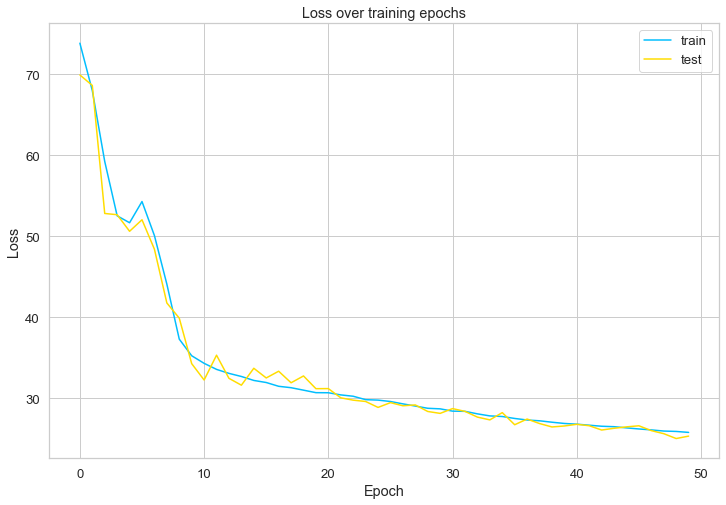

C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Correct normal predictions: 93/145


C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Correct anomaly predictions: 144/145


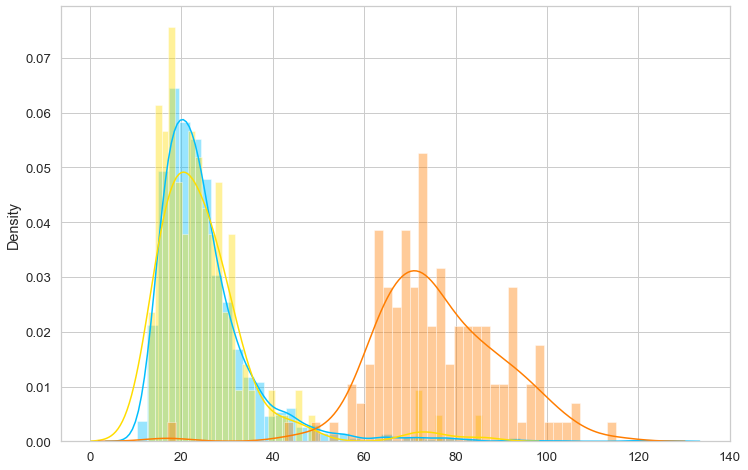

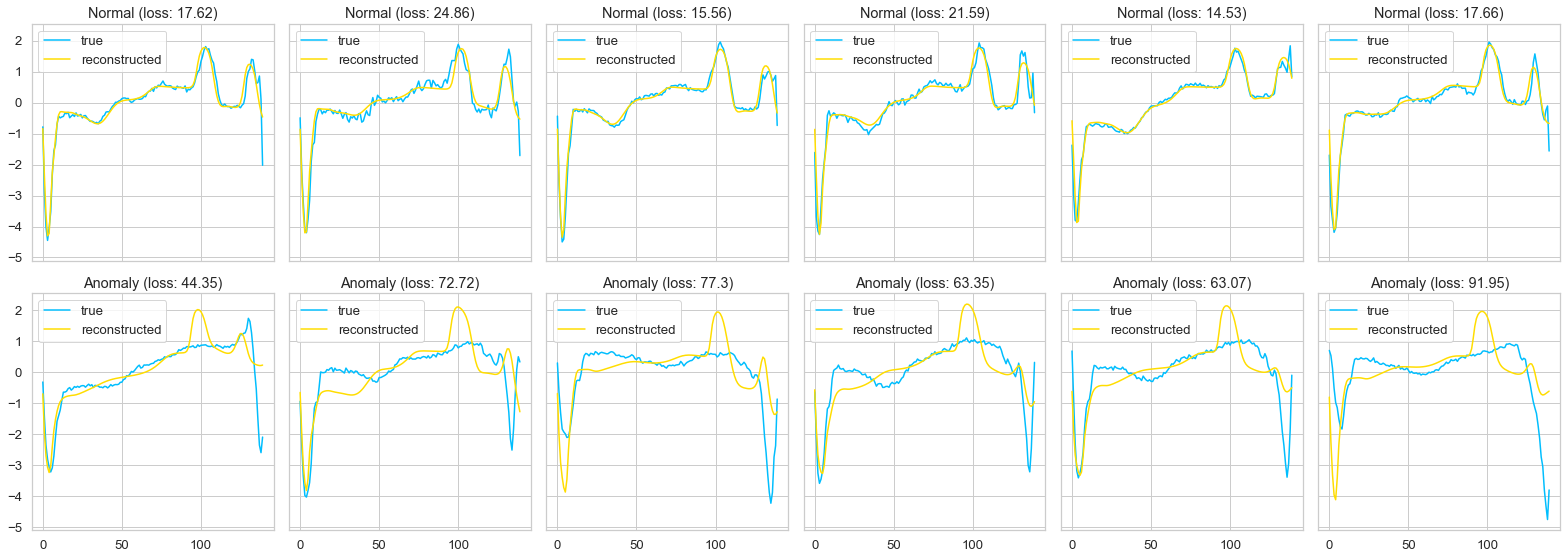

In [17]:
function275(25, 50)

Epoch 1: train loss 74.58577273767449 val loss 68.67714649499887
Epoch 2: train loss 69.17693794124408 val loss 68.69920850369711
Epoch 3: train loss 56.188181772966246 val loss 52.41801815879223
Epoch 4: train loss 52.76386887928211 val loss 51.39199881179341
Epoch 5: train loss 51.81862572881782 val loss 50.57166433497093
Epoch 6: train loss 50.88901883793761 val loss 48.482325192604456
Epoch 7: train loss 41.49683754908275 val loss 39.231326685830595
Epoch 8: train loss 36.09753777989453 val loss 41.53373740394775
Epoch 9: train loss 35.05283019678192 val loss 41.700520043487025
Epoch 10: train loss 34.55123481804303 val loss 38.44963826905339
Epoch 11: train loss 34.020562106205155 val loss 36.14256310056094
Epoch 12: train loss 33.45520302020269 val loss 38.30121283807852
Epoch 13: train loss 33.14793064804723 val loss 39.20609047144346
Epoch 14: train loss 32.65397074260043 val loss 38.479507550444616
Epoch 15: train loss 32.36376137600845 val loss 34.42174507245269
Epoch 16: tra

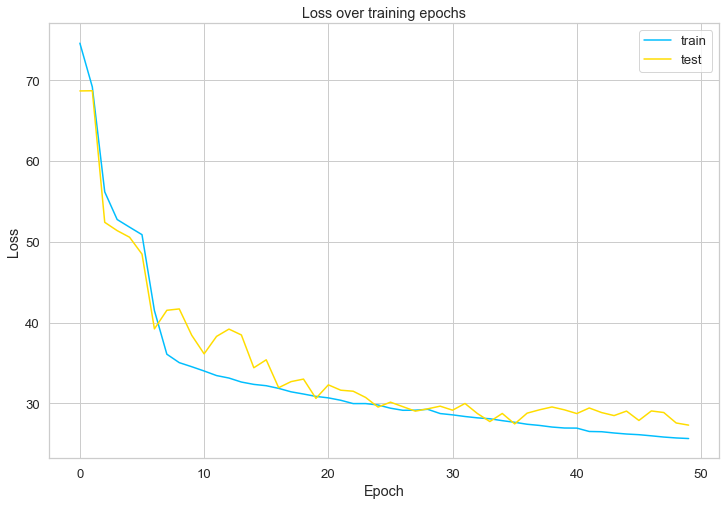

C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Correct normal predictions: 129/145


C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Correct anomaly predictions: 144/145


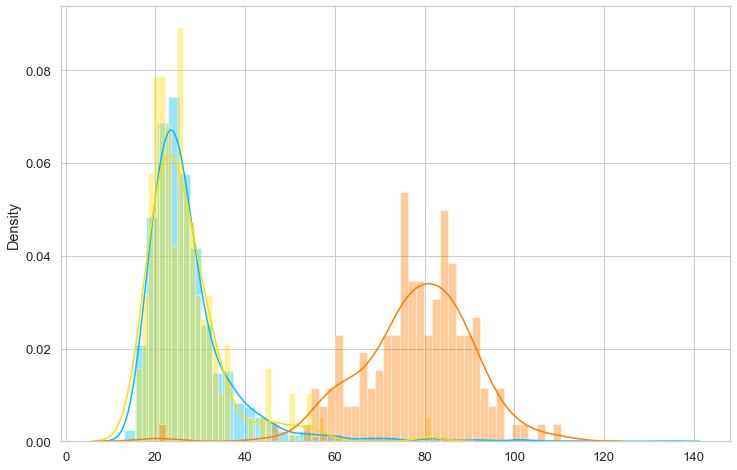

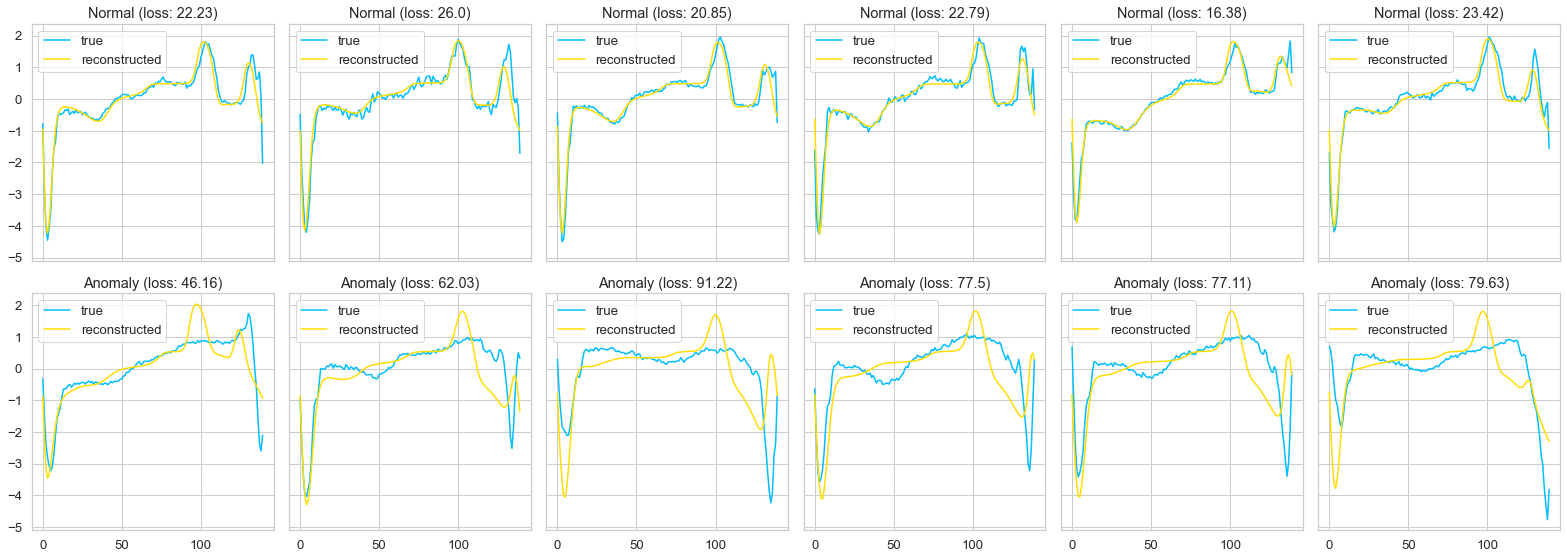

In [18]:
function275(35, 50)

Epoch 1: train loss 75.20450770244729 val loss 69.3710015462934
Epoch 2: train loss 68.63245497937646 val loss 68.20596396801008
Epoch 3: train loss 66.20684531695032 val loss 64.05609712828549
Epoch 4: train loss 62.03257106149067 val loss 57.733416169983535
Epoch 5: train loss 53.47815245228975 val loss 51.140041286221134
Epoch 6: train loss 48.08868767378168 val loss 48.06477693160646
Epoch 7: train loss 45.20422350288831 val loss 42.80681108858805
Epoch 8: train loss 41.29670471935587 val loss 42.18165199748485
Epoch 9: train loss 39.33920797865413 val loss 41.188275548785214
Epoch 10: train loss 37.49720380460961 val loss 38.51890866015958
Epoch 11: train loss 36.07995759609581 val loss 35.229133762190365
Epoch 12: train loss 35.51097657074134 val loss 37.0982211441717
Epoch 13: train loss 33.63333048660974 val loss 37.82852895430737
Epoch 14: train loss 35.94069741167209 val loss 35.68728438172324
Epoch 15: train loss 32.852007290856676 val loss 35.353159813343865
Epoch 16: train

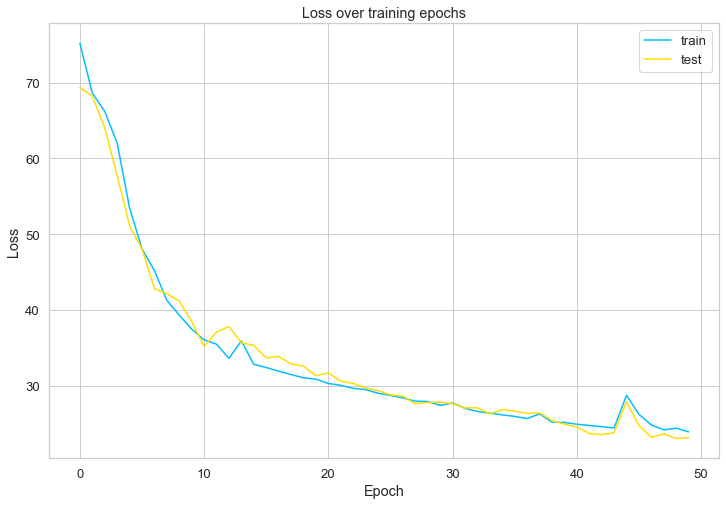

C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Correct normal predictions: 140/145


C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Correct anomaly predictions: 144/145


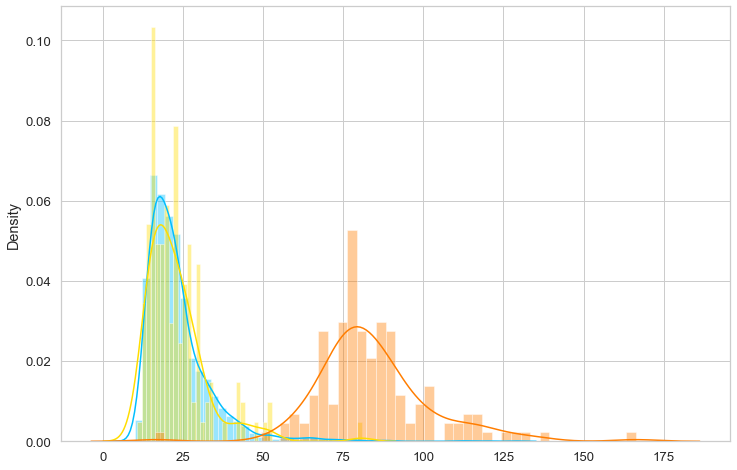

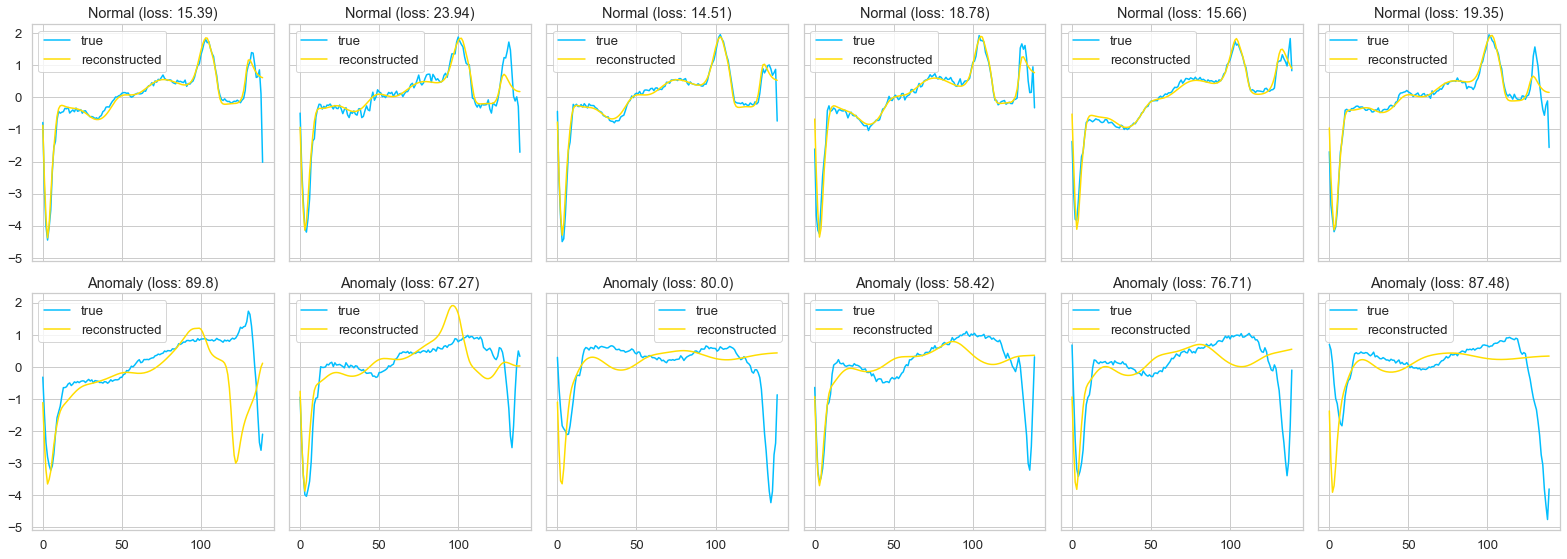

In [19]:
function275(45, 50)

Epoch 1: train loss 74.12862963293983 val loss 69.98852451832221
Epoch 2: train loss 67.32638031952999 val loss 61.37518695922435
Epoch 3: train loss 56.9284811731021 val loss 53.34386779993467
Epoch 4: train loss 50.75725949267042 val loss 47.80106193620597
Epoch 5: train loss 45.2172247968533 val loss 48.29256544666485
Epoch 6: train loss 41.22915689544493 val loss 45.21528558438142
Epoch 7: train loss 39.33707441893473 val loss 42.197653962483585
Epoch 8: train loss 38.191850148684935 val loss 39.21878482701428
Epoch 9: train loss 37.24204467410572 val loss 40.28473337843963
Epoch 10: train loss 36.42829089220471 val loss 38.37193177259009
Epoch 11: train loss 36.17913106390181 val loss 36.729278421239236
Epoch 12: train loss 35.04780708306838 val loss 36.4475006845624
Epoch 13: train loss 34.80378165777438 val loss 34.37198271767678
Epoch 14: train loss 34.412383519656615 val loss 33.591133644963286
Epoch 15: train loss 34.17353081232307 val loss 35.269953867681195
Epoch 16: train 

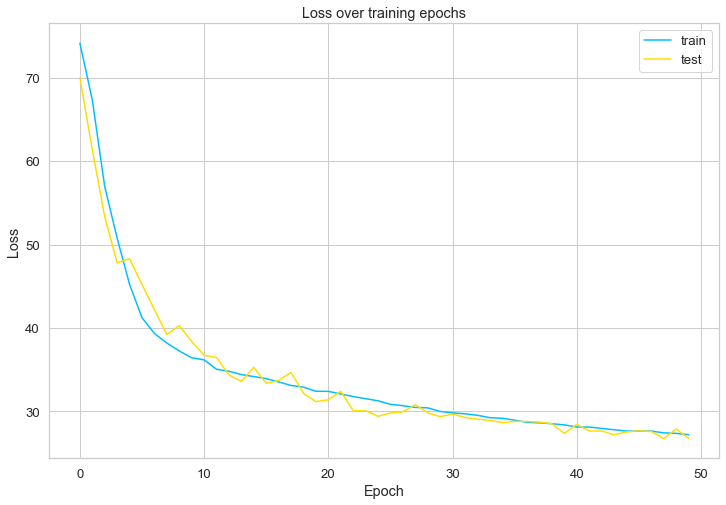

C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Correct normal predictions: 141/145


C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Correct anomaly predictions: 138/145


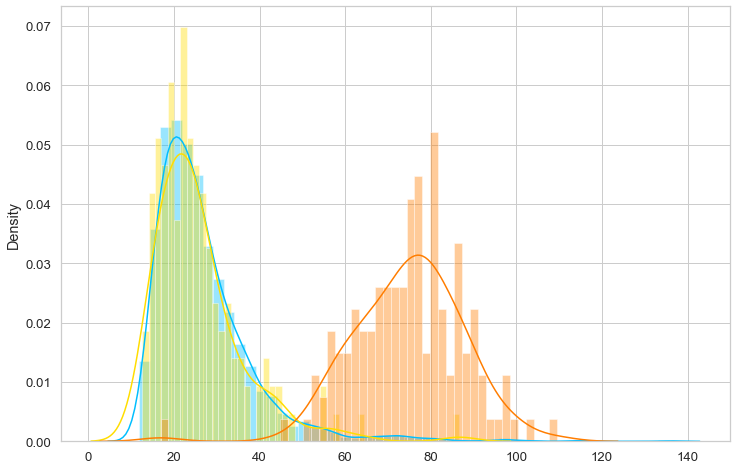

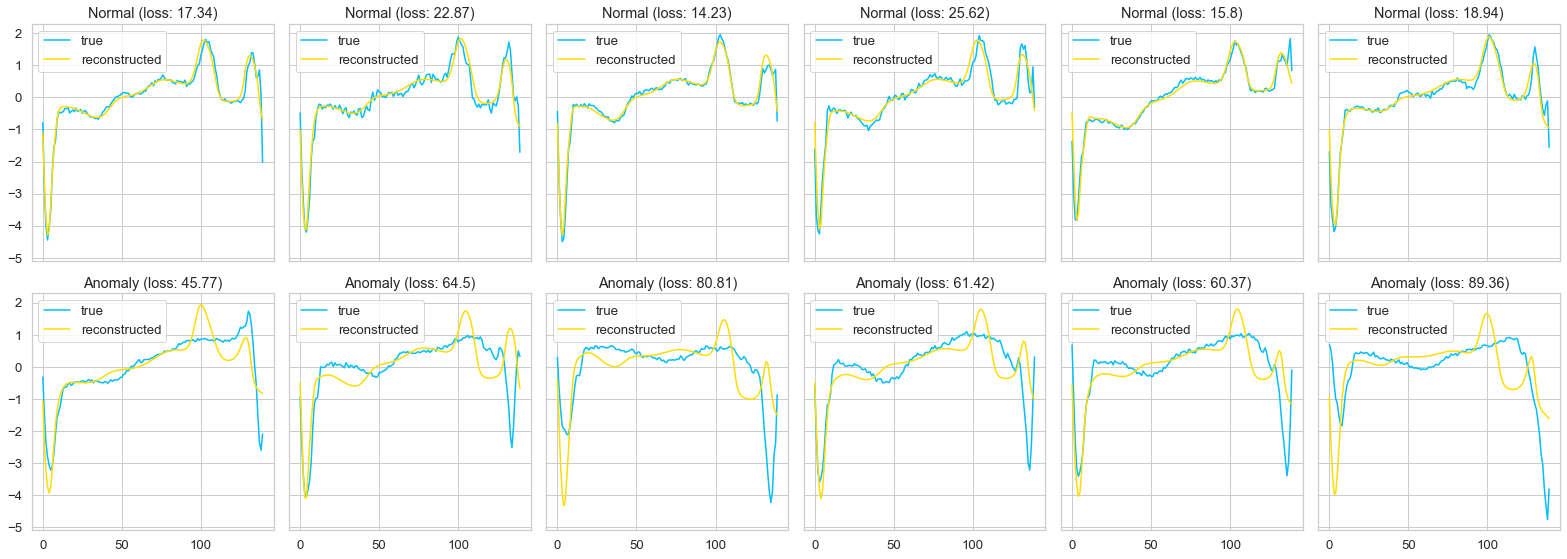

In [20]:
function275(55, 50)

In [6]:
def function275_2(embedding):
    # LSTM Autoencoder
    #The general Autoencoder architecture consists of two components. An *Encoder* that compresses the input and a *Decoder* that tries to reconstruct it.


    """Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:"""

    #model = RecurrentAutoencoder(seq_len, n_features, 128)
    #model = RecurrentAutoencoder(seq_len, n_features, 8)
    model = RecurrentAutoencoder(seq_len, n_features, embedding)
    model = model.to(device)


    """At each epoch, the training process feeds our model with all training examples and evaluates the performance on the validation set. Note that we're using a batch size of 1 (our model sees only 1 sequence at a time). We also record the training and validation set losses during the process.

    Note that we're minimizing the [L1Loss](https://pytorch.org/docs/stable/nn.html#l1loss), which measures the MAE (mean absolute error). Why? The reconstructions seem to be better than with MSE (mean squared error).

    We'll get the version of the model with the smallest validation error. Let's do some training:
    """

    model, history = train_model(
      model, 
      train_dataset, 
      val_dataset, 
      #n_epochs=epoch
      n_epochs=25  
    )

    ax = plt.figure().gca()

    ax.plot(history['train'])
    ax.plot(history['val'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'])
    plt.title('Loss over training epochs')
    plt.show();

    ## Saving the model

    #Let's store the model for later use:


    MODEL_PATH = 'model.pth'

    torch.save(model, MODEL_PATH)

    """## Choosing a threshold
    """



    _, losses = predict(model, train_dataset)

    sns.distplot(losses, bins=50, kde=True);

    THRESHOLD = 45

    """## Evaluation

    Using the threshold, we can turn the problem into a simple binary classification task:

    - If the reconstruction loss for an example is below the threshold, we'll classify it as a *normal* heartbeat
    - Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

    ### Normal hearbeats

    Let's check how well our model does on normal heartbeats. We'll use the normal heartbeats from the test set (our model haven't seen those):
    """

    predictions, pred_losses = predict(model, test_normal_dataset)
    sns.distplot(pred_losses, bins=50, kde=True);

    """We'll count the correct predictions:"""

    correct = sum(l <= THRESHOLD for l in pred_losses)
    print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

    """### Anomalies

    We'll do the same with the anomaly examples, but their number is much higher. We'll get a subset that has the same size as the normal heartbeats:
    """

    anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
    #anomaly_dataset = test_anomaly_dataset
    """Now we can take the predictions of our model for the subset of anomalies:"""

    predictions, pred_losses = predict(model, anomaly_dataset)
    sns.distplot(pred_losses, bins=50, kde=True);

    """Finally, we can count the number of examples above the threshold (considered as anomalies):"""

    correct = sum(l > THRESHOLD for l in pred_losses)
    print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

    #### Looking at Examples

    #We can overlay the real and reconstructed Time Series values to see how close they are. We'll do it for some normal and anomaly cases:


    fig, axs = plt.subplots(
      nrows=2,
      ncols=6,
      sharey=True,
      sharex=True,
      figsize=(22, 8)
    )

    for i, data in enumerate(test_normal_dataset[:6]):
        plot_prediction(data, model, title='Normal', ax=axs[0, i])

    for i, data in enumerate(test_anomaly_dataset[:6]):
        plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

    fig.tight_layout();

Epoch 1: train loss 93.41937376404424 val loss 86.75200533297281
Epoch 2: train loss 72.05823548212017 val loss 69.16592077834615
Epoch 3: train loss 69.00641463870534 val loss 69.66953376535669
Epoch 4: train loss 68.2182294514236 val loss 69.05969568975142
Epoch 5: train loss 67.85094749576764 val loss 68.90172134243181
Epoch 6: train loss 67.595356325813 val loss 68.92216067265325
Epoch 7: train loss 67.38965785969462 val loss 69.53639843520858
Epoch 8: train loss 67.20257237168005 val loss 69.25218458468596
Epoch 9: train loss 67.06096439907408 val loss 69.22260478413553
Epoch 10: train loss 66.95621784307072 val loss 66.79317851929127
Epoch 11: train loss 66.87527769181767 val loss 67.92136787961367
Epoch 12: train loss 66.78303765231973 val loss 66.80663595101939
Epoch 13: train loss 66.64352198043018 val loss 65.94737740995127
Epoch 14: train loss 66.5734642348622 val loss 65.84456973027044
Epoch 15: train loss 66.47693938932223 val loss 65.77079194885879
Epoch 16: train loss 66

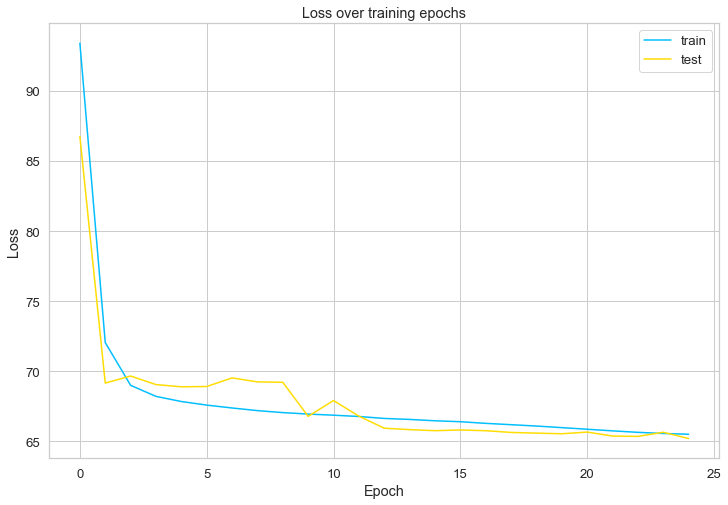

C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Correct normal predictions: 3/145


C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Correct anomaly predictions: 144/145


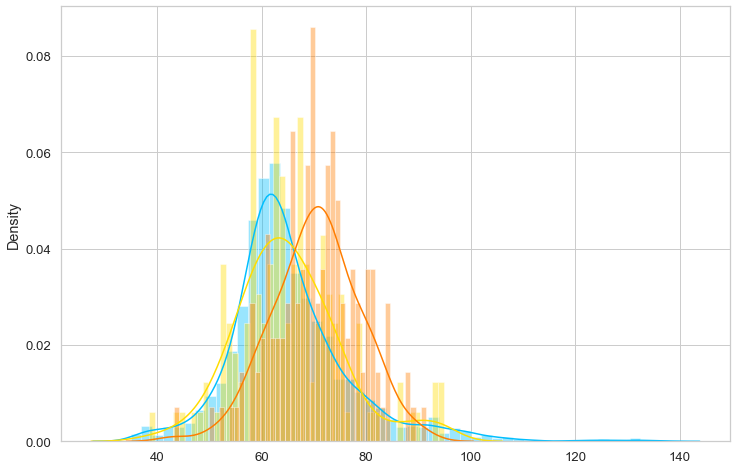

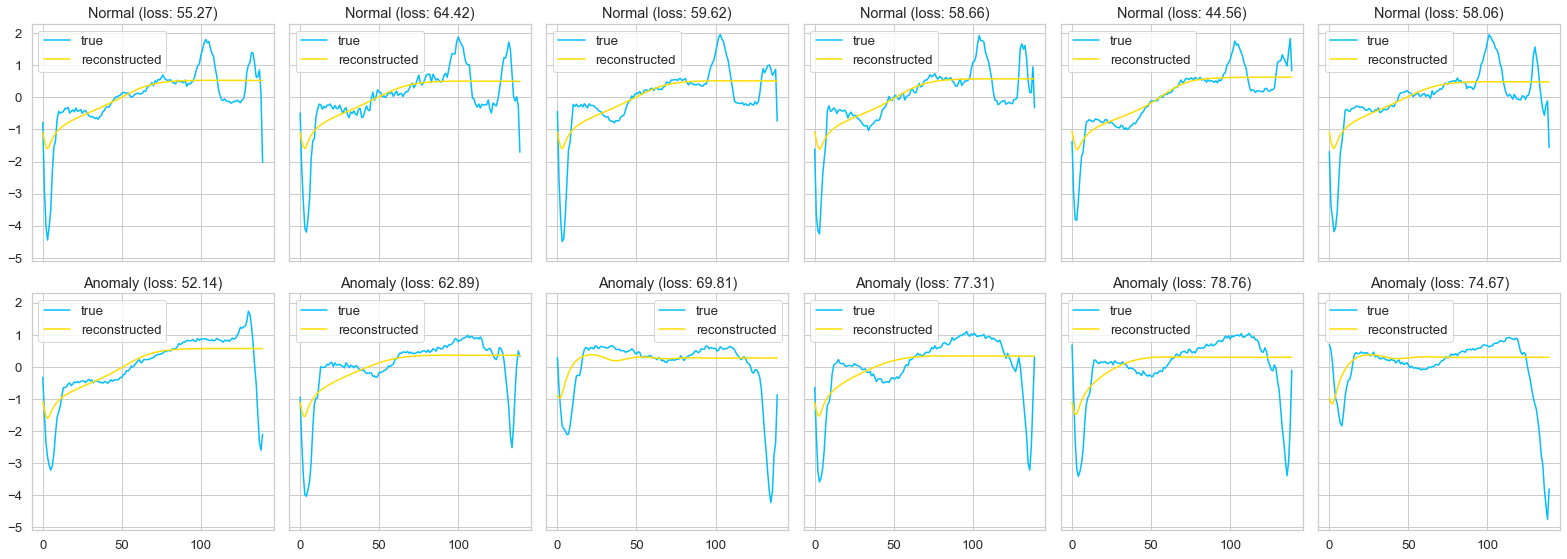

In [7]:
function275_2(2)

Epoch 1: train loss 78.93745142834074 val loss 70.28399108782563
Epoch 2: train loss 69.38951041341933 val loss 70.10411191556234
Epoch 3: train loss 68.73918197521131 val loss 69.18745881949675
Epoch 4: train loss 68.14545240944213 val loss 69.1599307662391
Epoch 5: train loss 67.39346747838505 val loss 67.80189400890988
Epoch 6: train loss 66.8775653339403 val loss 66.75784689737262
Epoch 7: train loss 64.69780192284851 val loss 65.06890971994237
Epoch 8: train loss 62.36122896747212 val loss 60.19651420775534
Epoch 9: train loss 58.94039760314376 val loss 56.72201993766498
Epoch 10: train loss 55.93459069214728 val loss 56.03681809096613
Epoch 11: train loss 53.65735418495753 val loss 53.9090899965462
Epoch 12: train loss 52.15397907735262 val loss 52.14012823007213
Epoch 13: train loss 51.15912977969728 val loss 51.01657912999697
Epoch 14: train loss 50.50869723531038 val loss 49.78718652822865
Epoch 15: train loss 50.17921276930502 val loss 49.47346747857312
Epoch 16: train loss 4

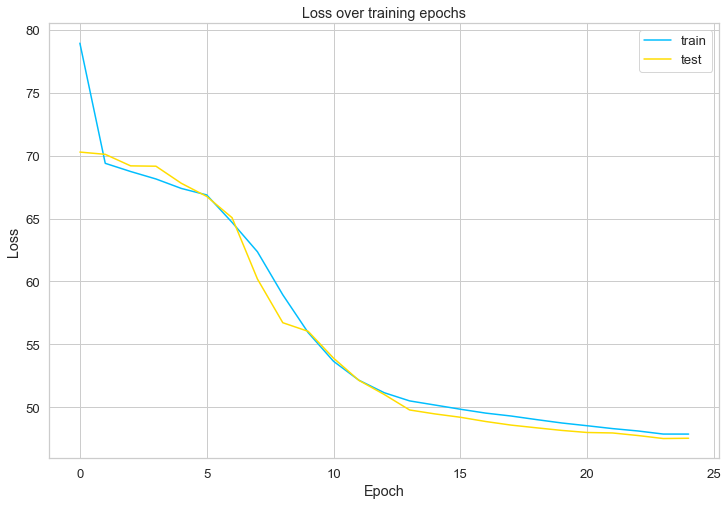

C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Correct normal predictions: 55/145


C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Correct anomaly predictions: 140/145


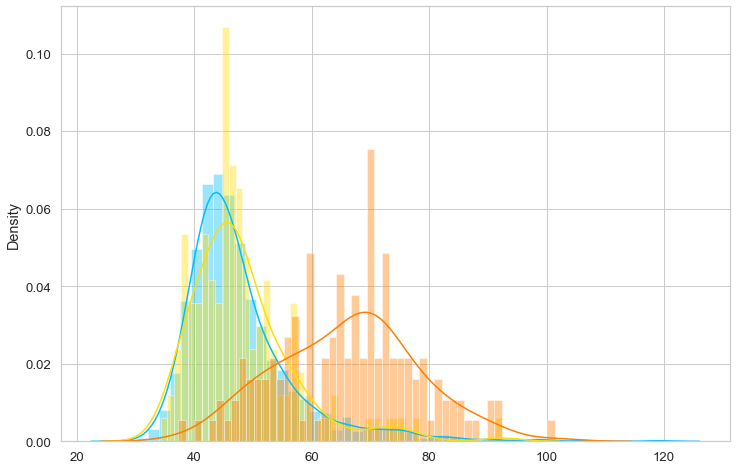

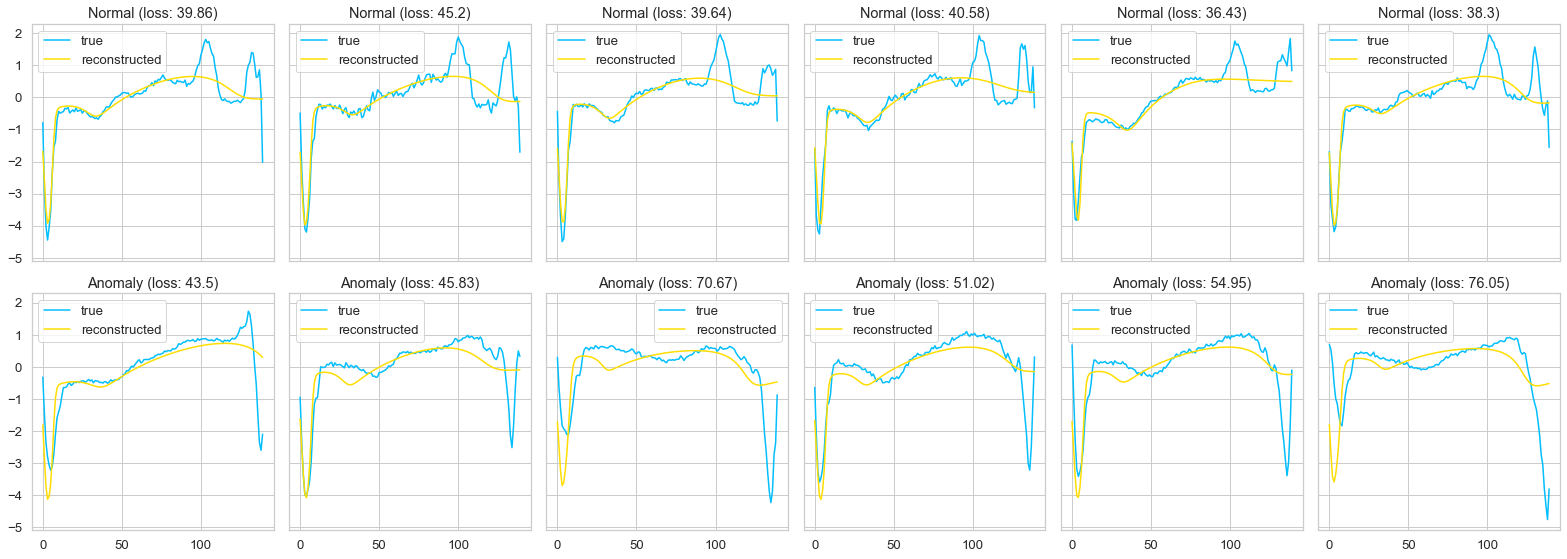

In [9]:
function275_2(4)

Epoch 1: train loss 75.9836693963232 val loss 69.1949533846598
Epoch 2: train loss 68.60743173386291 val loss 67.53947228701855
Epoch 3: train loss 65.65768269020336 val loss 63.12595561421365
Epoch 4: train loss 61.399441847826196 val loss 58.27142298831875
Epoch 5: train loss 55.22330393208846 val loss 53.19092800674178
Epoch 6: train loss 52.12301536646162 val loss 51.513462053630946
Epoch 7: train loss 51.280965767383385 val loss 50.63380253762515
Epoch 8: train loss 50.75254557316268 val loss 50.30897415213211
Epoch 9: train loss 50.33456970577709 val loss 49.615310057031415
Epoch 10: train loss 50.077468263963596 val loss 49.325426459719296
Epoch 11: train loss 49.719762416964144 val loss 49.09406656779527
Epoch 12: train loss 49.46357292073814 val loss 48.75426423915824
Epoch 13: train loss 49.24653322588095 val loss 48.89749940995877
Epoch 14: train loss 49.07283804100495 val loss 48.80337996368929
Epoch 15: train loss 48.84795778559754 val loss 48.40617887477419
Epoch 16: trai

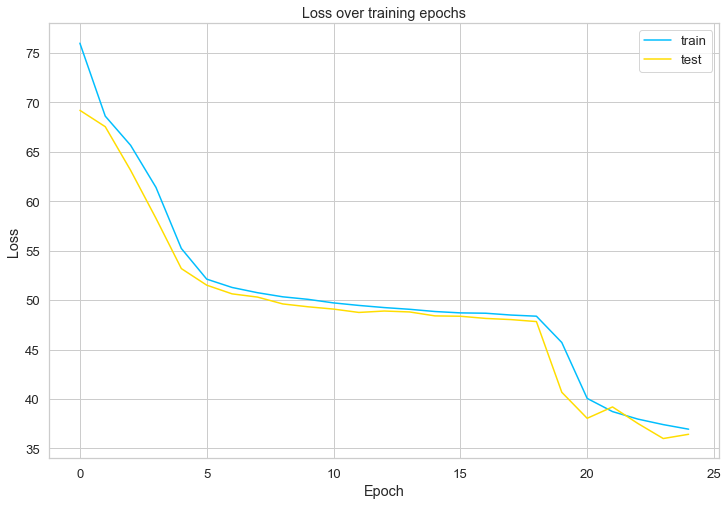

C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Correct normal predictions: 127/145


C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Correct anomaly predictions: 144/145


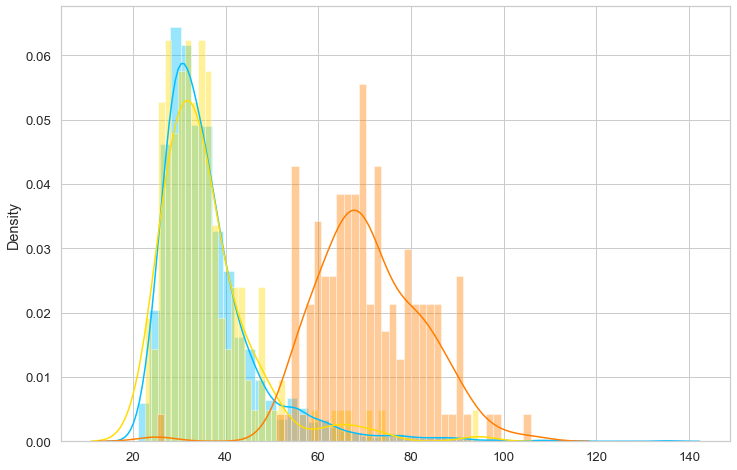

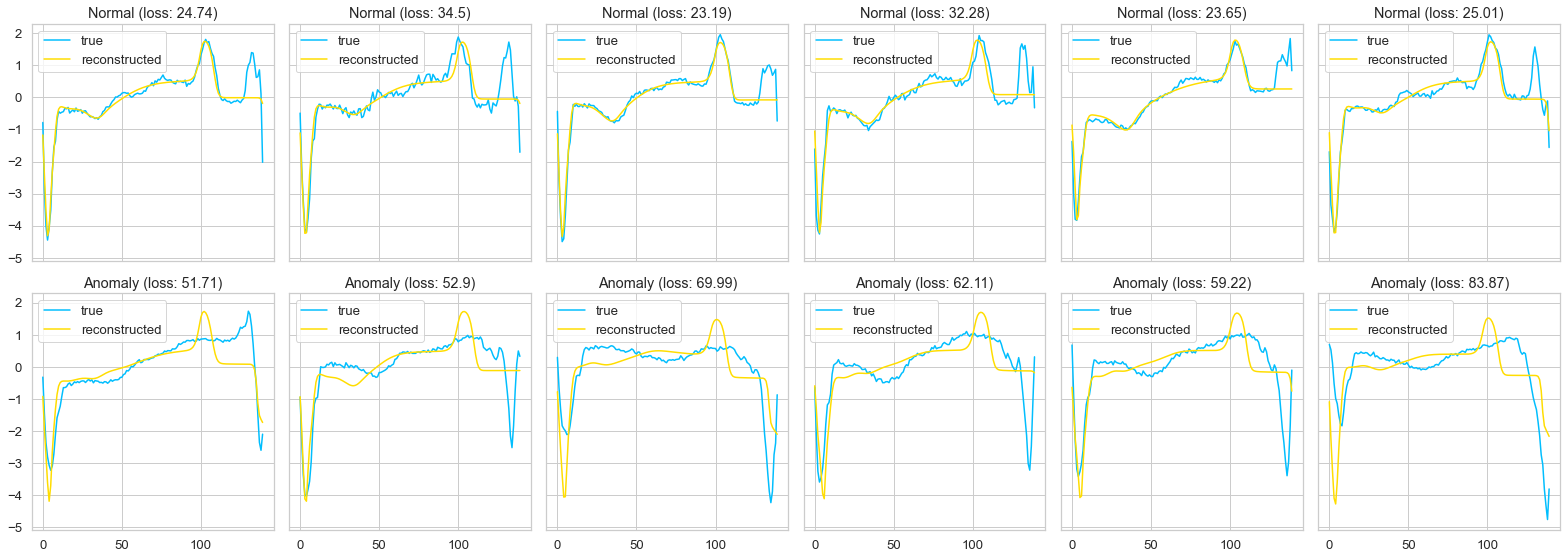

In [10]:
function275_2(6)

Epoch 1: train loss 73.89845827557012 val loss 64.96540944486755
Epoch 2: train loss 58.28590096854625 val loss 54.2840536462569
Epoch 3: train loss 53.38529464017475 val loss 52.205683724465224
Epoch 4: train loss 51.865337484837156 val loss 51.34951127348499
Epoch 5: train loss 50.930275949726465 val loss 49.958271339077996
Epoch 6: train loss 50.388678169019855 val loss 49.36784102404077
Epoch 7: train loss 49.954583829566864 val loss 49.2096175301197
Epoch 8: train loss 49.655273231466374 val loss 49.403512733381355
Epoch 9: train loss 49.280808706717934 val loss 49.08973880676686
Epoch 10: train loss 49.08247782481577 val loss 48.70195454542141
Epoch 11: train loss 48.189926719434894 val loss 44.54413898975776
Epoch 12: train loss 39.59482880976353 val loss 40.52003416510572
Epoch 13: train loss 37.117511993740315 val loss 36.90104813950054
Epoch 14: train loss 35.904500644565445 val loss 35.555688561839865
Epoch 15: train loss 35.15610439149856 val loss 34.09982902604972
Epoch 16

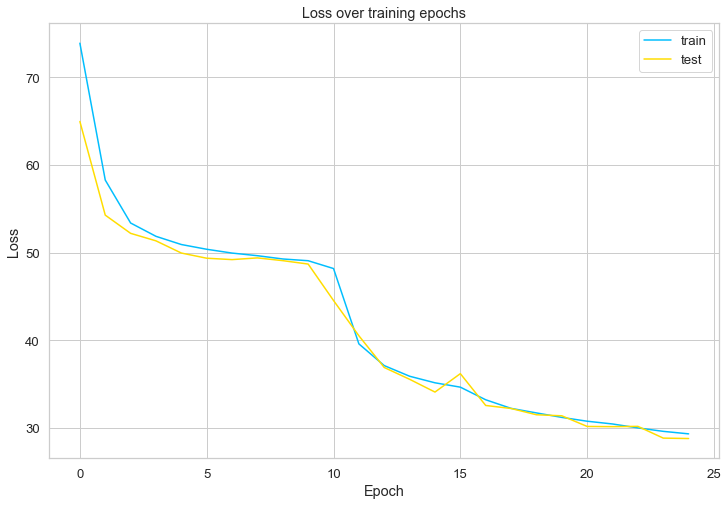

C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Correct normal predictions: 136/145


C:\Users\Joyce\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Correct anomaly predictions: 144/145


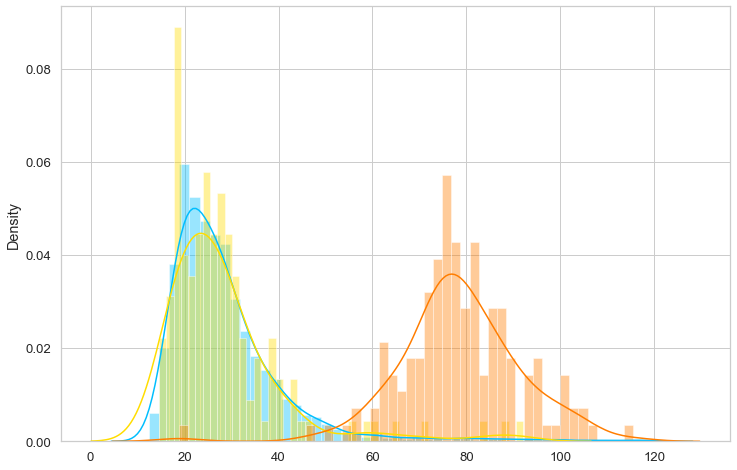

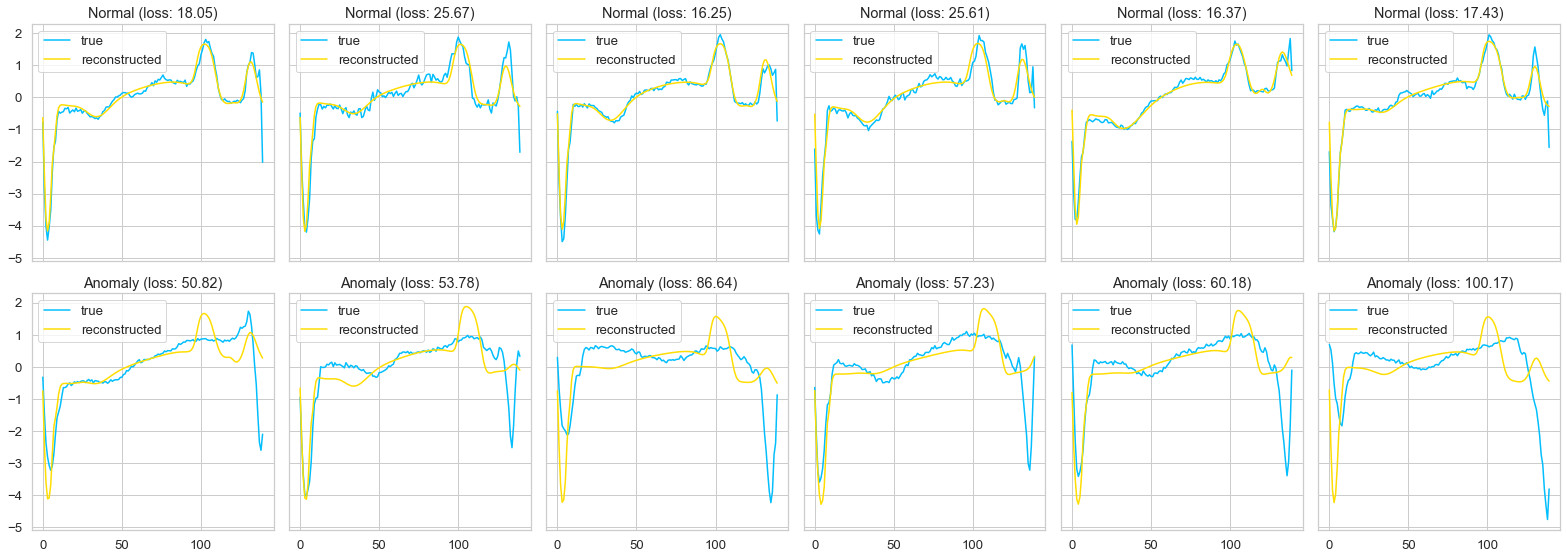

In [11]:
function275_2(8)